In [43]:
#import the libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [44]:
#Store the data into the df variable
df = pd.read_csv('../../data/dump.csv')

In [45]:
#Set the date as the index for the data
df = df.set_index(pd.DatetimeIndex(df['time'].values))
#Show the dataframe
# df

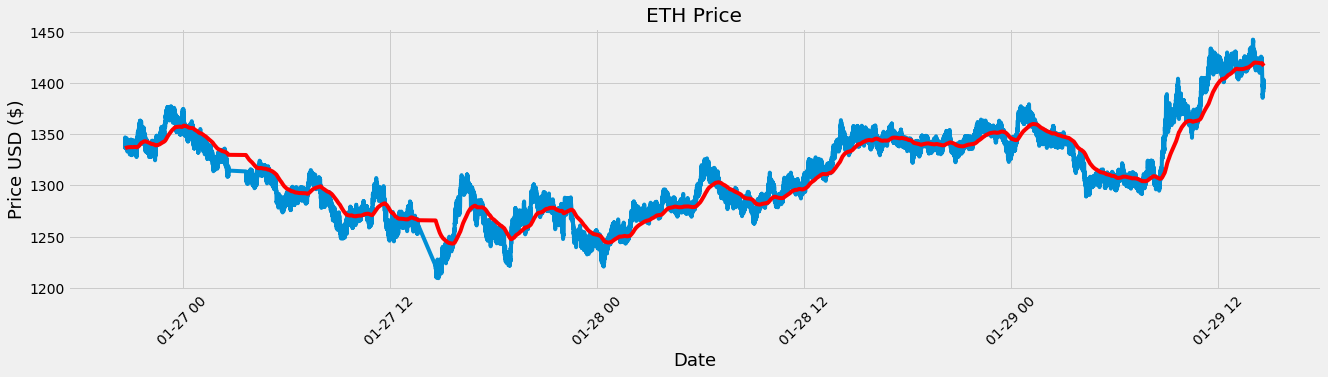

In [46]:
# Visually Show The Stock Price(s)
# Create the title
title = 'ETH Price'
#Get the stocks
my_stocks = df
#Create and plot the graph
plt.figure(figsize=(20,4.5)) #width = 12.2in, height = 4.5
plt.plot( my_stocks['price'],  label='price')#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)

just_ema = df.price.ewm(span=400, adjust=False).mean()
plt.plot(df.index, just_ema, label='Exponential moving average', color = 'red')

plt.xticks(rotation=45) 
plt.title(title)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD ($)',fontsize=18)
plt.show()

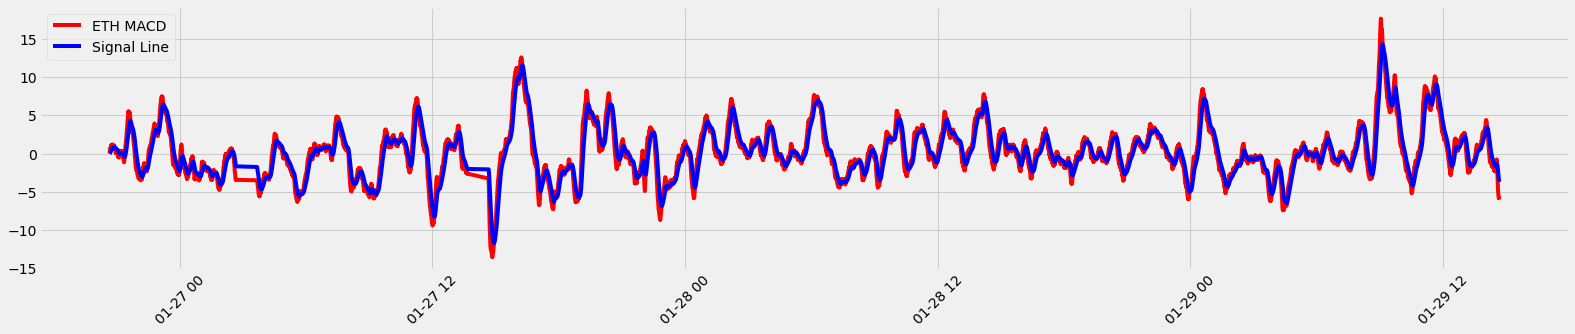

In [47]:

def createMacdAndSignalLines(macd_params, macd_multiplier):
    ShortEMA = df.price.ewm(span=macd_params[0]*macd_multiplier, adjust=False).mean() #AKA Fast moving average
    LongEMA = df.price.ewm(span=macd_params[1]*macd_multiplier, adjust=False).mean() #AKA Slow moving average
    Macd = ShortEMA - LongEMA
    signal = Macd.ewm(span=macd_params[2]*macd_multiplier, adjust=False).mean()
    return (Macd, signal)

macd_params = (12, 26, 9)
macd_multiplier = 5
macd, signal = createMacdAndSignalLines(macd_params, macd_multiplier)

plt.figure(figsize=(12.2*2,4.5)) #width = 12.2in, height = 4.5
plt.plot(df.index, macd, label='ETH MACD', color = 'red')
plt.plot(df.index, signal, label='Signal Line', color='blue')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

In [48]:
df['MACD'] = macd
df['Signal Line'] = signal

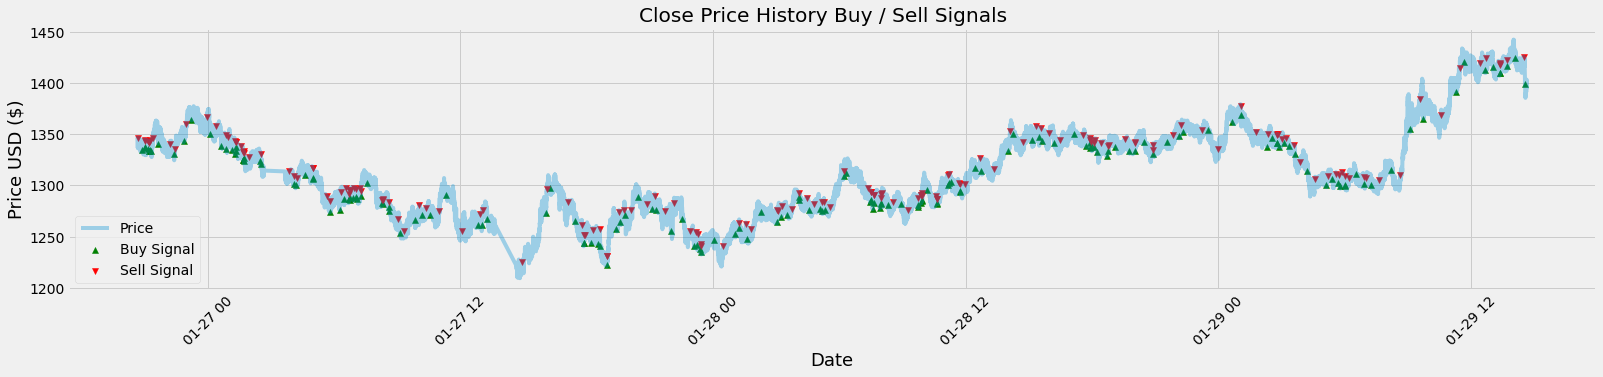

2021-01-26T21:01:15Z Bought at 1334.91  selling at 1344.485 for profit: 7.574999999999818
2021-01-26T21:01:45Z Bought at 1336.26  selling at 1343.495 for profit: 5.2349999999999
2021-01-26T21:09:15Z Bought at 1337.77  selling at 1343.38 for profit: 3.6100000000001273
2021-01-26T21:10:00Z Bought at 1335.06  selling at 1342.965 for profit: 5.904999999999973
2021-01-26T21:13:30Z Bought at 1333.47  selling at 1341.12 for profit: 5.649999999999864
2021-01-26T21:15:15Z Bought at 1333.555  selling at 1343.02 for profit: 7.464999999999918
2021-01-26T21:15:45Z Bought at 1334.99  selling at 1343.87 for profit: 6.879999999999882
2021-01-26T21:23:00Z Bought at 1333.45  selling at 1346.595 for profit: 11.144999999999982
2021-01-26T22:12:30Z Bought at 1340.405  selling at 1340.0 for profit: -2.4049999999999727
2021-01-26T22:26:45Z Bought at 1330.405  selling at 1335.855 for profit: 3.4500000000000455
2021-01-26T22:58:30Z Bought at 1343.07  selling at 1360.11 for profit: 15.039999999999964
2021-01-26

In [49]:
# Function to test the crossover driven profits of the macd and signal lines
def mac_daddy_tester(macd, signal, df):
    bought = False
    sumwin = 0
    transactions = []
    for i in range(1, len(signal)):
        if ( (macd.iat[i] < signal.iat[i]) and (macd.iat[i-1] >= signal.iat[i-1]) and bought == False):
            # print("Crossed above, time to buy", i)
            bought = df.iat[i,1]
        if ( (macd.iat[i] > signal.iat[i]) and (macd.iat[i-1] <= signal.iat[i-1]) and bought):
            # print("Crossed below, time to sell", i)
            print(df.iat[i,0], "Bought at", bought, " selling at", df.iat[i,1], "for profit:", df.iat[i,1] - bought - 2)
            transactions.append(df.iat[i,1] - bought)
            sumwin = sumwin + df.iat[i,1] - bought - 1
            bought = False 
    return(sumwin, transactions)


#Create a function to signal when to buy and sell an asset
def buy_sell(signal):
  sigPriceBuy = []
  sigPriceSell = []
  flag = -1
  for i in range(0,len(signal)):
    #if MACD > signal line  then buy else sell
      if signal['MACD'][i] < signal['Signal Line'][i]:
        if flag != 1:
          sigPriceBuy.append(signal['price'][i])
          sigPriceSell.append(np.nan)
          flag = 1
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
      elif signal['MACD'][i] > signal['Signal Line'][i]: 
        if flag != 0:
          sigPriceSell.append(signal['price'][i])
          sigPriceBuy.append(np.nan)
          flag = 0
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
      else: #Handling nan values
        sigPriceBuy.append(np.nan)
        sigPriceSell.append(np.nan)
  
  return (sigPriceBuy, sigPriceSell)


#Create buy and sell columns
x = buy_sell(df)
df['Buy_Signal_Price'] = x[0]
df['Sell_Signal_Price'] = x[1]

# Visually Show The Stock buy and sell signals
# Create the title 
title = 'Close Price History Buy / Sell Signals   '
#Get the stocks
my_stocks = df
  
#Create and plot the graph
plt.figure(figsize=(12.2*2,4.5)) #width = 12.2in, height = 4.5
plt.scatter(my_stocks.index, my_stocks['Buy_Signal_Price'], color = 'green', label='Buy Signal', marker = '^', alpha = 1)
plt.scatter(my_stocks.index, my_stocks['Sell_Signal_Price'], color = 'red', label='Sell Signal', marker = 'v', alpha = 1)
plt.plot( my_stocks['price'],  label='Price', alpha = 0.35)#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)
plt.xticks(rotation=45)
plt.title(title)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD ($)',fontsize=18)
plt.legend( loc='lower left')
plt.show()

r = mac_daddy_tester(macd, signal, df)
print("Profit", r[0])
print("trans: ", len(r[1]))
# print(r[1])

In [50]:
# results = []
# for period_length in np.arange(5, 700, 5):
#     macd_params = (12, 26, 9)
#     macd_multiplier = period_length #was 111
#     macd, signal = createMacdAndSignalLines(macd_params, macd_multiplier)
#     r = mac_daddy_tester(macd, signal, df)
#     results.append((period_length, r[0], len(r[1])))
#     # print(period_length, "Profit", r[0], "transactions: ", len(r[1]))
# sorted(results, key = lambda x: -x[1])